In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from sklearn.metrics import roc_auc_score
from scipy.stats import zscore

from sklearn.decomposition import PCA

from sklearn.metrics import classification_report

In [34]:
# Примерный пайплайн:
# 1) Считываем данные
# 2) Убираем null и лишние поля
# 3) Мерджим датафреймы
# 4) Кодирование категориальных признаков
# 5) опционально - посмотреть корреляцию, убрать лишние признаки
# 6) Масштабирование
# 7) Балансирование классов SMOTE
# 8) Кfold 
# 9) Обучение модели
# 10) Валидация результатов

# сначала базово попробовать настроить нормальный ROC-AUC

# + PCA, регуляризация(???), генерация признаков и PSI

In [35]:
ar = pd.read_csv('data/application_record.zip', compression='zip')
cr = pd.read_csv('data/credit_record.zip', compression='zip')

# Предобработка данных

In [36]:
ar.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [37]:
cr.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## Очистка данных

In [38]:
# проверяем дублирующиеся ID
ar.duplicated(subset=['ID']).sum()

47

In [39]:
ar.drop_duplicates('ID', keep='last', inplace=True)

In [40]:
# информация о месяце просрочки не понадобится
cr.drop('MONTHS_BALANCE', axis=1, inplace=True)

In [41]:
cr['STATUS'].value_counts() 

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

- **0:** 1-29 days past due 
- **1:** 30-59 days past due 
- **2:** 60-89 days overdue 
- **3:** 90-119 days overdue 
- **4:** 120-149 days overdue 
- **5:** Overdue or bad debts, write-offs for more than 150 days 
- **C:** paid off that month 
- **X:** No loan for the month

In [42]:
cr['STATUS'] = cr['STATUS'].replace({'C' : 0, 'X' : 0})
cr['STATUS'] = cr['STATUS'].astype(int)
cr['STATUS'] = cr['STATUS'].apply(lambda x: 1 if x >= 1 else 0)
cr['STATUS'].value_counts() 

0    1034381
1      14194
Name: STATUS, dtype: int64

In [43]:
df = ar.join(cr.set_index('ID'), on='ID', how='inner')
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0


<AxesSubplot:>

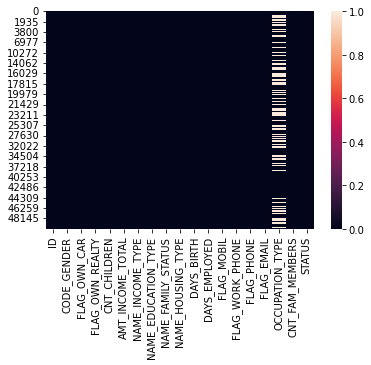

In [44]:
# проверяем наличие пропущенных значений с помощью визуализации
sns.heatmap(df.isnull())

In [45]:
# удаляем строки, в которых пропущено поле OCCUPATION_TYPE
df.dropna(axis=0, inplace=True)

In [46]:
df.isna().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
STATUS                 0
dtype: int64

In [47]:
df['STATUS'].value_counts() 

0    529282
1      8385
Name: STATUS, dtype: int64

In [48]:
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'STATUS'],
      dtype='object')

## Кодирование категориальных признаков

In [49]:
# попробуем просто заменить на 0 и 1
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].replace({'Y' : 1, 'N' : 0})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].replace({'Y' : 1, 'N' : 0})
df['CODE_GENDER'] = df['CODE_GENDER'].replace({'F' : 1, 'M' : 0})

In [50]:
#  кодируем категориальный порядковый признак
le = LabelEncoder()
df['NAME_INCOME_TYPE'] = le.fit_transform(df['NAME_INCOME_TYPE'])
df['NAME_HOUSING_TYPE'] = le.fit_transform(df['NAME_HOUSING_TYPE'])
df['NAME_EDUCATION_TYPE'] = le.fit_transform(df['NAME_EDUCATION_TYPE']) #
df['NAME_FAMILY_STATUS'] = le.fit_transform(df['NAME_FAMILY_STATUS']) #
df['OCCUPATION_TYPE'] = le.fit_transform(df['OCCUPATION_TYPE']) #

In [51]:
# попробовать OHE или др способы кодирования

## Проверяем наличие выбросов

<AxesSubplot:xlabel='ID', ylabel='CODE_GENDER'>

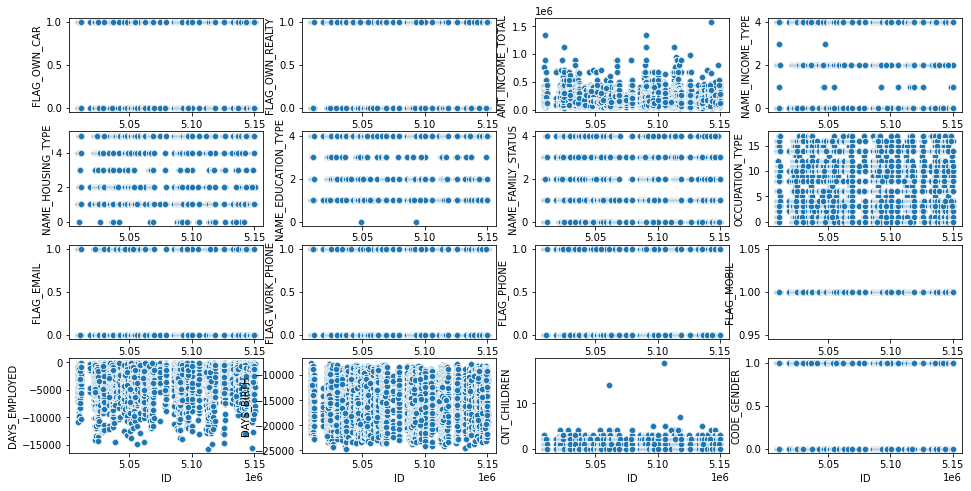

In [52]:
# проверяем наличие выбросов с помощью визуализации

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,8))
sns.scatterplot(x=df['ID'], y=df['FLAG_OWN_CAR'], data=df, ax=ax[0][0])
sns.scatterplot(x=df['ID'], y=df['FLAG_OWN_REALTY'], data=df, ax=ax[0][1])
sns.scatterplot(x=df['ID'], y=df['AMT_INCOME_TOTAL'], data=df, ax=ax[0][2])
sns.scatterplot(x=df['ID'], y=df['NAME_INCOME_TYPE'], data=df, ax=ax[0][3])


sns.scatterplot(x=df['ID'], y=df['NAME_HOUSING_TYPE'], data=df, ax=ax[1][0])
sns.scatterplot(x=df['ID'], y=df['NAME_EDUCATION_TYPE'], data=df, ax=ax[1][1])
sns.scatterplot(x=df['ID'], y=df['NAME_FAMILY_STATUS'], data=df, ax=ax[1][2])
sns.scatterplot(x=df['ID'], y=df['OCCUPATION_TYPE'], data=df, ax=ax[1][3])


sns.scatterplot(x=df['ID'], y=df['FLAG_EMAIL'], data=df, ax=ax[2][0])
sns.scatterplot(x=df['ID'], y=df['FLAG_WORK_PHONE'], data=df, ax=ax[2][1])
sns.scatterplot(x=df['ID'], y=df['FLAG_PHONE'], data=df, ax=ax[2][2])
sns.scatterplot(x=df['ID'], y=df['FLAG_MOBIL'], data=df, ax=ax[2][3])

sns.scatterplot(x=df['ID'], y=df['DAYS_EMPLOYED'], data=df, ax=ax[3][0])
sns.scatterplot(x=df['ID'], y=df['DAYS_BIRTH'], data=df, ax=ax[3][1])
sns.scatterplot(x=df['ID'], y=df['CNT_CHILDREN'], data=df, ax=ax[3][2])
sns.scatterplot(x=df['ID'], y=df['CODE_GENDER'], data=df, ax=ax[3][3])

In [53]:
variances = df.select_dtypes(include=['number']).var()
print("Дисперсия признаков:\n", variances)

Дисперсия признаков:
 ID                     1.764168e+09
CODE_GENDER            2.353861e-01
FLAG_OWN_CAR           2.451687e-01
FLAG_OWN_REALTY        2.296836e-01
CNT_CHILDREN           6.198172e-01
AMT_INCOME_TOTAL       1.084492e+10
NAME_INCOME_TYPE       3.148480e+00
NAME_EDUCATION_TYPE    1.853086e+00
NAME_FAMILY_STATUS     7.518042e-01
NAME_HOUSING_TYPE      9.921572e-01
DAYS_BIRTH             1.167191e+07
DAYS_EMPLOYED          5.730850e+06
FLAG_MOBIL             0.000000e+00
FLAG_WORK_PHONE        2.023083e-01
FLAG_PHONE             2.095564e-01
FLAG_EMAIL             9.058334e-02
OCCUPATION_TYPE        1.837802e+01
CNT_FAM_MEMBERS        8.776917e-01
STATUS                 1.535197e-02
dtype: float64


Выбросы присутствуют по следующим признакам: AMT_INCOME_TOTAL, CNT_CHILDREN

In [54]:
# Вычисляем Z-оценки и удаляем выбросы (|Z| > 3)
df['z_score'] = zscore(df['AMT_INCOME_TOTAL'])
df = df[np.abs(df['z_score']) <= 3]

In [55]:
# Вычисляем Z-оценки и удаляем выбросы (|Z| > 3)
df['z_score'] = zscore(df['CNT_CHILDREN'])
df = df[np.abs(df['z_score']) <= 3]

In [56]:
df.drop('z_score', axis=1, inplace=True)

In [57]:
# У признака FLAG_MOBIL нулевая дисперсия (это видно и на графике), его можно удалить
df.drop('FLAG_MOBIL', axis=1, inplace=True)

In [58]:
# Посмотрим еще раз дисперсию после удаления выбросов
variances = df.select_dtypes(include=['number']).var()
print("Дисперсия признаков:\n", variances)

Дисперсия признаков:
 ID                     1.761900e+09
CODE_GENDER            2.348859e-01
FLAG_OWN_CAR           2.444388e-01
FLAG_OWN_REALTY        2.303517e-01
CNT_CHILDREN           4.710622e-01
AMT_INCOME_TOTAL       7.008767e+09
NAME_INCOME_TYPE       3.134355e+00
NAME_EDUCATION_TYPE    1.839142e+00
NAME_FAMILY_STATUS     7.617413e-01
NAME_HOUSING_TYPE      9.991097e-01
DAYS_BIRTH             1.175013e+07
DAYS_EMPLOYED          5.809347e+06
FLAG_WORK_PHONE        2.025666e-01
FLAG_PHONE             2.097092e-01
FLAG_EMAIL             9.050125e-02
OCCUPATION_TYPE        1.840186e+01
CNT_FAM_MEMBERS        7.214246e-01
STATUS                 1.520021e-02
dtype: float64


## Исследование данных

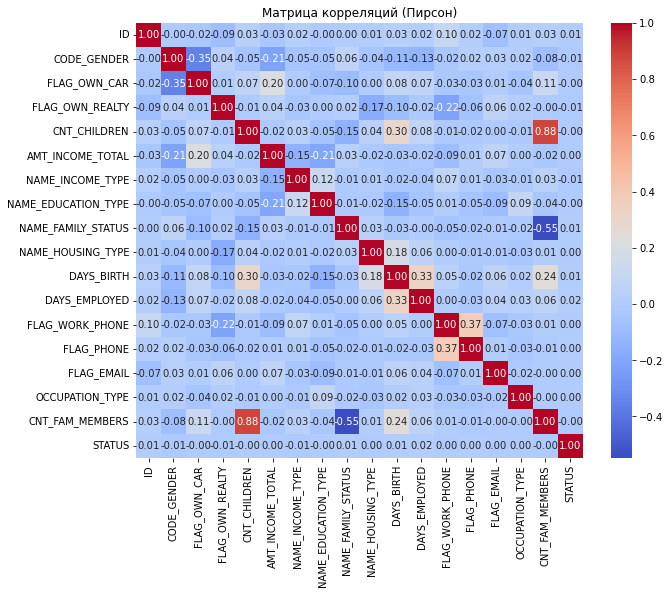

In [59]:
# Вычисление матрицы корреляций
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций (Пирсон)')
plt.show()

Высокая корреляция признаков CNT_FAM_MEMBERS и CNT_CHILDREN. Попробуем дропнуть CNT_FAM_MEMBERS.

In [60]:
df.drop('CNT_FAM_MEMBERS', axis=1, inplace=True) # это никак не повлияло

## Генерация признаков и проверка их стабильности с помощью PSI

In [61]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,STATUS
2,5008806,0,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,0
2,5008806,0,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,0
2,5008806,0,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,0
2,5008806,0,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,0
2,5008806,0,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,0


In [62]:
df['INCOME/AGE'] = df['AMT_INCOME_TOTAL'] / (-df['DAYS_BIRTH'])
df['DAYS_BIRTH/DAYS_EMPLOYED'] = (-df['DAYS_BIRTH']) / (-df['DAYS_EMPLOYED'])
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,STATUS,INCOME/AGE,DAYS_BIRTH/DAYS_EMPLOYED
2,5008806,0,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,0,5.238894,18.936508
2,5008806,0,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,0,5.238894,18.936508
2,5008806,0,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,0,5.238894,18.936508
2,5008806,0,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,0,5.238894,18.936508
2,5008806,0,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,0,5.238894,18.936508


In [63]:
X_psi = df.loc[:, ~df.columns.isin(['ID', 'STATUS'])]
y_psi = df['STATUS']

In [64]:
X_train_psi, X_test_psi, y_train_psi, y_test_psi = train_test_split(X_psi, y_psi, random_state=42, stratify=y_psi)

In [65]:
def calculate_psi(expected, actual, bins=10, epsilon=1e-6):
    # Разбиваем данные на бины
    breakpoints = np.histogram_bin_edges(expected, bins=bins)
    expected_counts, _ = np.histogram(expected, bins=breakpoints)
    actual_counts, _ = np.histogram(actual, bins=breakpoints)
    
    # Добавляем epsilon, чтобы избежать деления на ноль
    expected_counts = expected_counts + epsilon
    actual_counts = actual_counts + epsilon
    
    # Нормализуем до процентов
    expected_percents = expected_counts / np.sum(expected_counts)
    actual_percents = actual_counts / np.sum(actual_counts)
    
    # Рассчитываем PSI
    psi = np.sum((actual_percents - expected_percents) * np.log(actual_percents / expected_percents))
    
    return psi

def calculate_psi_for_dataframe(df_expected, df_actual, bins=10):
    psi_results = {}

    
    for column in df_expected.columns:
        expected = df_expected[column]
        actual = df_actual[column]
        psi_value = calculate_psi(expected, actual, bins=bins)
        psi_results[column] = psi_value
    
    return psi_results

In [66]:
# Рассчитываем PSI для всех признаков
psi_results = calculate_psi_for_dataframe(X_train_psi, X_test_psi, bins=10)

# Выводим результаты
for feature, psi in psi_results.items():
    print(f"PSI для признака {feature}: {psi:.4f}")

PSI для признака CODE_GENDER: 0.0000
PSI для признака FLAG_OWN_CAR: 0.0000
PSI для признака FLAG_OWN_REALTY: 0.0000
PSI для признака CNT_CHILDREN: 0.0000
PSI для признака AMT_INCOME_TOTAL: 0.0001
PSI для признака NAME_INCOME_TYPE: 0.0000
PSI для признака NAME_EDUCATION_TYPE: 0.0000
PSI для признака NAME_FAMILY_STATUS: 0.0001
PSI для признака NAME_HOUSING_TYPE: 0.0000
PSI для признака DAYS_BIRTH: 0.0001
PSI для признака DAYS_EMPLOYED: 0.0001
PSI для признака FLAG_WORK_PHONE: 0.0000
PSI для признака FLAG_PHONE: 0.0000
PSI для признака FLAG_EMAIL: 0.0000
PSI для признака OCCUPATION_TYPE: 0.0002
PSI для признака INCOME/AGE: 0.0001
PSI для признака DAYS_BIRTH/DAYS_EMPLOYED: 0.0001


# Обучение модели

In [67]:
X = df.loc[:, ~df.columns.isin(['ID', 'STATUS'])]
y = df['STATUS']

In [68]:
X_PCA = PCA(n_components=3).fit_transform(X)

In [69]:
# делим датасет на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, random_state=42, stratify=y)

In [70]:
# приводим данные к одной шкале
mms = MinMaxScaler()
X_scaled = mms.fit_transform(X_train)
X_test_scaled = mms.transform(X_test)

In [71]:
# делаем перебалансировку
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y_train)

In [72]:
xgb = XGBClassifier(random_state = 42, n_estimators = 300)
model = xgb.fit(X_balanced, y_balanced)
xgb_prediction = xgb.predict(X_test_scaled)
feature_importances = model.feature_importances_
print(feature_importances)

[0.327117   0.32531714 0.3475659 ]


In [73]:
print(f"xgb train score = {xgb.score(X_balanced, y_balanced)}")
print(f"xgb test score = {xgb.score(X_test, y_test)}")

# xgb train score = 0.9126463304959429
# xgb test score = 0.984406734267243

xgb train score = 0.8923980789256905
xgb test score = 0.9845595886637694


In [74]:
print(classification_report(y_test, xgb_prediction)) #1 xgb

#               precision    recall  f1-score   support

#            0       1.00      0.86      0.92    128678
#            1       0.08      0.75      0.14      2018

#     accuracy                           0.86    130696
#    macro avg       0.54      0.80      0.53    130696
# weighted avg       0.98      0.86      0.91    130696

              precision    recall  f1-score   support

           0       1.00      0.86      0.92    128678
           1       0.08      0.75      0.14      2018

    accuracy                           0.86    130696
   macro avg       0.54      0.80      0.53    130696
weighted avg       0.98      0.86      0.91    130696



In [75]:
# Вычисляем AUC
auc = roc_auc_score(y_test, xgb_prediction)

# Вычисляем коэффициент Джини
gini = 2 * auc - 1
print(f"xgb AUC: {auc}")
print(f"xgb Gini: {gini}")

# xgb AUC: 0.8043987796244838
# xgb Gini: 0.6087975592489676

xgb AUC: 0.8043987796244838
xgb Gini: 0.6087975592489676


In [76]:
cm = confusion_matrix(y_test, xgb_prediction)
print("Confusion Matrix:\n", cm)

# Confusion Matrix:
#  [[110604  18074]
#  [   506   1512]]

Confusion Matrix:
 [[110604  18074]
 [   506   1512]]


In [77]:
# object_type = pd.DataFrame(df.dtypes =='object').reset_index()
# object_type = object_type[object_type[0] == True]['index']
# object_type

In [78]:
# df['FLAG_OWN_CAR'].value_counts() # binary encoder

In [79]:
# df['FLAG_OWN_REALTY'].value_counts()

In [80]:
# df['NAME_INCOME_TYPE'].value_counts() # не все значения одинаково часто встречаются, TargetEncoding не подойдет, но порядковый - LabelEncoding

In [81]:
# df['NAME_HOUSING_TYPE'].value_counts() # не все значения одинаково часто встречаются, target encoding не подойдет -> BinaryEncoding

In [82]:
# mean_encoding = df.groupby('NAME_FAMILY_STATUS')['STATUS'].mean()
# df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].map(mean_encoding)

In [83]:
# encoder = BinaryEncoder(cols=['DAYS_BIRTH'])
# df = encoder.fit_transform(df)

In [84]:
# classifiers = {
#     "LogisticRegression" : LogisticRegression(max_iter=1000),
#     "KNeighbors" : KNeighborsClassifier(),
#     "SVC" : SVC(),
#     "DecisionTree" : DecisionTreeClassifier(),
#     "RandomForest" : RandomForestClassifier(),
#     "XGBoost" : XGBClassifier()
# }

In [85]:
# train_scores = []
# test_scores = []

# for key, classifier in classifiers.items():
#     classifier.fit(X_balanced, y_balanced)
#     train_score = classifier.score(X_balanced, y_balanced)
#     train_scores.append(train_score)
#     test_score = classifier.score(X_test, y_test)
#     test_scores.append(test_score)

# print(train_scores)
# print(test_scores)

In [86]:
# import shap

# # Создание explainer
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_balanced)

# # Визуализация значимости признаков
# shap.summary_plot(shap_values, X_balanced, feature_names=X_balanced.columns)

In [87]:
# explainer = shap.TreeExplainer(model)
# shap_values = explainer(X_balanced)
# shap.plots.waterfall(shap_values[0])

In [88]:
# explainer = shap.TreeExplainer(model)
# shap_values = explainer(X_balanced)
# shap.plots.waterfall(shap_values[1])

In [89]:
# shap.plots.bar(shap_values)

In [90]:
# logreg = LogisticRegression(max_iter=1000)
# model = logreg.fit(X_balanced, y_balanced)
# train_score = logreg.score(X_balanced, y_balanced)
# test_score = logreg.score(X_test, y_test)
# logreg_prediction = logreg.predict(X_test)

# print(f"logreg train score = {train_score}")
# print(f"logreg test score = {test_score}")

In [91]:
# print(classification_report(y_test, logreg_prediction)) #logreg

In [92]:
# # Вычисляем AUC
# auc = roc_auc_score(y_test, logreg_prediction)

# # Вычисляем коэффициент Джини
# gini = 2 * auc - 1
# print(f"logreg AUC: {auc}")
# print(f"logreg Gini: {gini}")